# Notebook for re-plotting the trajectories and such from csv's containing data from results generation
## Note, the notebook is nice for visualization, but slow. Use the .py file for speed and realiability...

In [39]:
%load_ext autoreload
%autoreload 2
# Reloads changed modules before executing a cell :)

from ctypes.wintypes import PWIN32_FIND_DATAA

import pandas as pd
import numpy as np
import pyvista as pv
pv.global_theme.jupyter_backend = 'static'
#pv.set_jupyter_backend('trame')

import sys
import os
# Add the parent directory to the system path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

from pv_plotting_3d import Plotter3D, Plotter3DMultiTraj
from gym_quad.envs.LV_VAE_MESH import LV_VAE_MESH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import the testresults data from wanted scene

In [40]:
exp_dir = f'Best_agent_res_gen_2 exp 32'
trained_scen = "advanced"
test_scen = "cave"  # house_easy, house_easy_obs, house_hard, house_hard_obs, cave
model_name = "test_agent_model_10000"
retrieve_data_path = os.path.join(parent_dir, 'log', 'LV_VAE_MESH-v0', exp_dir , trained_scen, 'results_gen', test_scen, model_name)
output_path = os.path.join(parent_dir, 'plotting', 'replotting_results', exp_dir , trained_scen, 'results_gen', test_scen, model_name)
# "C:\Users\admin\Desktop\EirikJorgenMasterCode\gym_quad\log\LV_VAE_MESH-v0\Best_agent_res_gen_2 exp 32\advanced\results_gen\horizontal\test_agent_model_10000\sim_df.csv"
# 'c:\\Users\\admin\\Desktop\\EirikJorgenMasterCode\\gym_quad\\log\\LV_VAE_MESH-v0\\Best_agent_res_gen_2 exp 32\\advanced\\results_gen\\horizontal\\test_agent_model 10000/sim_df.csv'
# Load the data
sim_data = pd.read_csv(retrieve_data_path + '/sim_df.csv')
metrics_data = pd.read_csv(retrieve_data_path + '/test_summary.csv')

In [41]:
sim_data.head()

Episode     Reward  Time   Progression       $X$       $Y$       $Z$  \
0      0.0 -11.051591  0.01  1.899952e-08 -0.393025  0.021031 -1.507992   
1      0.0 -10.605805  0.02  1.899952e-08 -0.393020  0.021003 -1.507515   
2      0.0 -10.649213  0.03  1.899952e-08 -0.392997  0.020886 -1.506579   
3      0.0 -10.748471  0.04  1.899952e-08 -0.392938  0.020591 -1.505209   
4      0.0 -10.871545  0.05  1.899952e-08 -0.392813  0.020035 -1.503455   

     $\phi$  $\theta$    $\psi$  ...     obs12     obs13     obs14     obs15  \
0  0.000228  0.002346 -1.273834  ...  0.434499  0.323989  0.328603  0.338195   
1  0.001118  0.008848 -1.264689  ...  0.434842  0.304794  0.315629  0.368583   
2  0.002580  0.018373 -1.249244  ...  0.437466  0.332391  0.345625  0.330534   
3  0.003811  0.027966 -1.229266  ...  0.434961  0.333347  0.306092  0.351670   
4  0.004441  0.035871 -1.206038  ...  0.436693  0.343945  0.297325  0.356391   

      obs16  obs17     obs18     obs19     obs20     obs21  
0 -0.723893    1.0  0.592862  0.008040  0.004302  0.000044  
1 -0.542717    1.0  1.000000 -0.004795 -0.008281  0.011002  
2 -0.439157    1.0  1.000000 -0.010726  0.013447  0.011422  
3 -0.504008    1.0  1.000000 -0.004708 -0.005816  0.026832  
4 -0.464309    1.0  1.000000 -0.005473  0.015381  0.032706  

[5 rows x 64 columns]

In [42]:
metrics_data.head()

Episode  Timesteps  Avg Absolute Path Error  Speed   IAE Cross  \
0        0        147                 0.748748    NaN   24.636870   
1        1        410                 0.280961    NaN   90.719314   
2        2        500                 1.065179    NaN  387.622910   
3        3        432                 0.431838    NaN  172.973485   
4        4        383                 0.410365    NaN  148.616967   

   IAE Vertical  Progression  Success  Collision  Avg Speed  
0    106.422999     0.008423        0          1   0.344047  
1     41.246712     0.973295        1          0   1.052234  
2    285.373031     0.039997        0          1   0.712622  
3     52.624354     0.974547        1          0   1.082341  
4     31.575347     0.971727        1          0   1.119900

In [43]:
"""import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html"""

'import sys\nimport torch\npyt_version_str=torch.__version__.split("+")[0].replace(".", "")\nversion_str="".join([\n    f"py3{sys.version_info.minor}_cu",\n    torch.version.cuda.replace(".",""),\n    f"_pyt{pyt_version_str}"\n])\n!pip install iopath\n!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html'

### Create env to create scenes:

In [44]:
from drl_config import lv_vae_config
replot_config = lv_vae_config.copy()
replot_config["mesh_path"] = os.path.join(parent_dir, 'gym_quad', 'meshes', 'sphere.obj')
replot_config["max_t_steps"] = 0
env = LV_VAE_MESH(env_config=replot_config,scenario=test_scen)
obstacles = env.unwrapped.obstacles
path = env.unwrapped.path

CAVE


/home/thomas/github_repos/jorgenlf/venv39/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


### For plotting single trajectories:

In [45]:
"""#decide which episode to plot
episode = 0
episode_df = sim_data[sim_data["Episode"]==episode]
drone_traj = np.stack((episode_df[r"$X$"], episode_df[r"$Y$"], episode_df[r"$Z$"]), axis=-1)
init_pos = drone_traj[0]

#Make sure the output path exists
os.makedirs(os.path.join(output_path, "plots"), exist_ok=True)

plotter = Plotter3D(obstacles=obstacles, 
                            path=path, 
                            drone_traj=drone_traj,
                            initial_position=init_pos,
                            save=True,
                            scene=test_scen) 
plotter.plot_scene_and_trajs(save_path=os.path.join(output_path, "plots", f"episode{episode}.png"), hv=1, only_scene=False)
del plotter"""

'#decide which episode to plot\nepisode = 0\nepisode_df = sim_data[sim_data["Episode"]==episode]\ndrone_traj = np.stack((episode_df[r"$X$"], episode_df[r"$Y$"], episode_df[r"$Z$"]), axis=-1)\ninit_pos = drone_traj[0]\n\n#Make sure the output path exists\nos.makedirs(os.path.join(output_path, "plots"), exist_ok=True)\n\nplotter = Plotter3D(obstacles=obstacles, \n                            path=path, \n                            drone_traj=drone_traj,\n                            initial_position=init_pos,\n                            save=True,\n                            scene=test_scen) \nplotter.plot_scene_and_trajs(save_path=os.path.join(output_path, "plots", f"episode{episode}.png"), hv=1, only_scene=False)\ndel plotter'

### For plotting multiple trajectories


In [46]:
#Make sure the output path exists
os.makedirs(os.path.join(output_path, "plots"), exist_ok=True)
cum_rewards = {}
successes = {}
collisions = {}
all_drone_trajs = {}
all_init_pos = {}

for episode in sim_data["Episode"].unique():
    episode_df = sim_data[sim_data["Episode"]==episode]
    metrics_df = metrics_data[metrics_data["Episode"]==episode]
    drone_traj = np.stack((episode_df[r"$X$"], episode_df[r"$Y$"], episode_df[r"$Z$"]), axis=-1)
    init_pos = drone_traj[0]
    all_drone_trajs[episode] = drone_traj
    all_init_pos[episode] = all_drone_trajs[episode][0]
    cum_rewards[episode] = episode_df["Reward"].sum()
    successes[episode] = metrics_df["Success"].sum()
    collisions[episode] = metrics_df["Collision"].sum()



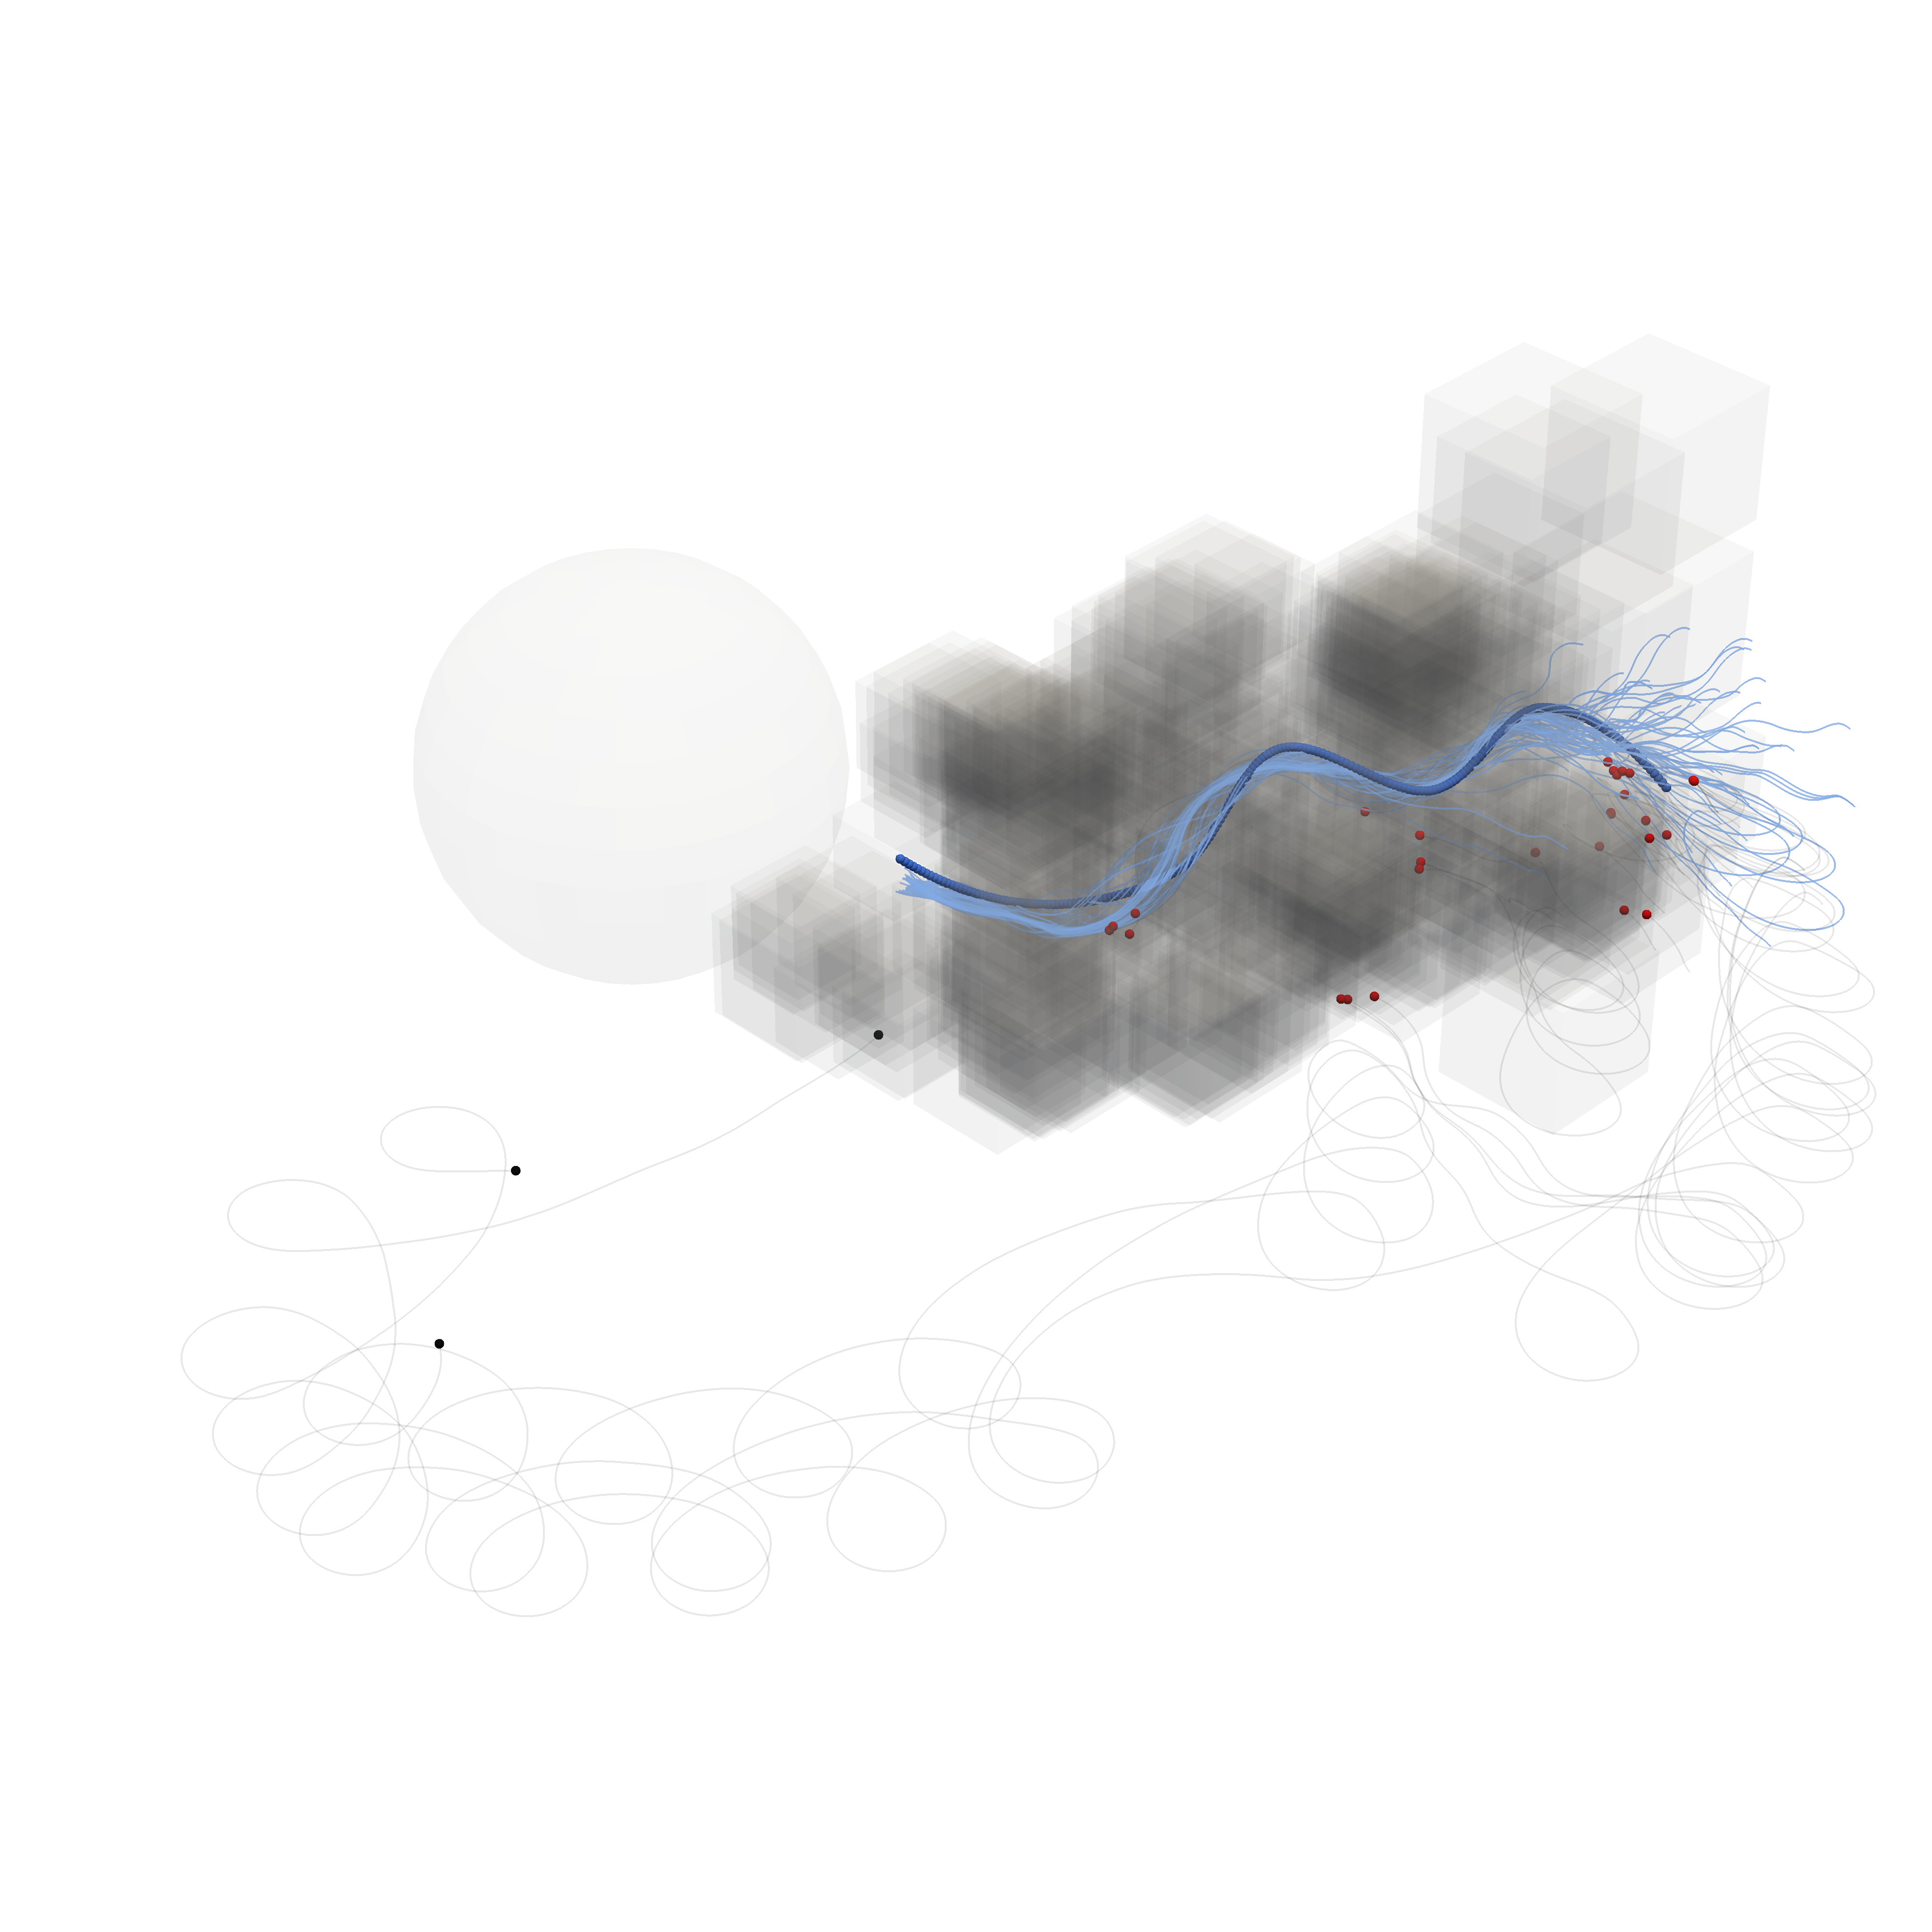

In [47]:
# Plot House_hard view 1

if test_scen in ["house_hard", "house_hard_obstacles"]:
    for hv in [1,2,3,4]: # View from two angles, must have separate instances. Solved with hv variable in plotter func. "hv=HouseView"
        multiplotter = Plotter3DMultiTraj(obstacles=obstacles,
                                            path=path,
                                            drone_trajs=all_drone_trajs,
                                            initial_position=init_pos,
                                            cum_rewards=successes,  # cum_rewards,
                                            scene=test_scen,
                                            save=True)
        multiplotter.plot_scene_and_trajs(save_path=os.path.join(output_path, "plots", f"multiplot_hv{hv}.pdf"),
                                        azimuth=90,
                                        hv=hv)
        #del multiplotter
else:
    multiplotter = Plotter3DMultiTraj(obstacles=obstacles,
                                    path=path,
                                    drone_trajs=all_drone_trajs,
                                    initial_position=init_pos,
                                    cum_rewards=successes,  # cum_rewards,
                                    scene=test_scen,
                                    collisions=collisions,
                                    save=True)
    multiplotter.plot_scene_and_trajs(save_path=os.path.join(output_path, "plots", f"multiplot.pdf"),
                                    azimuth=90)

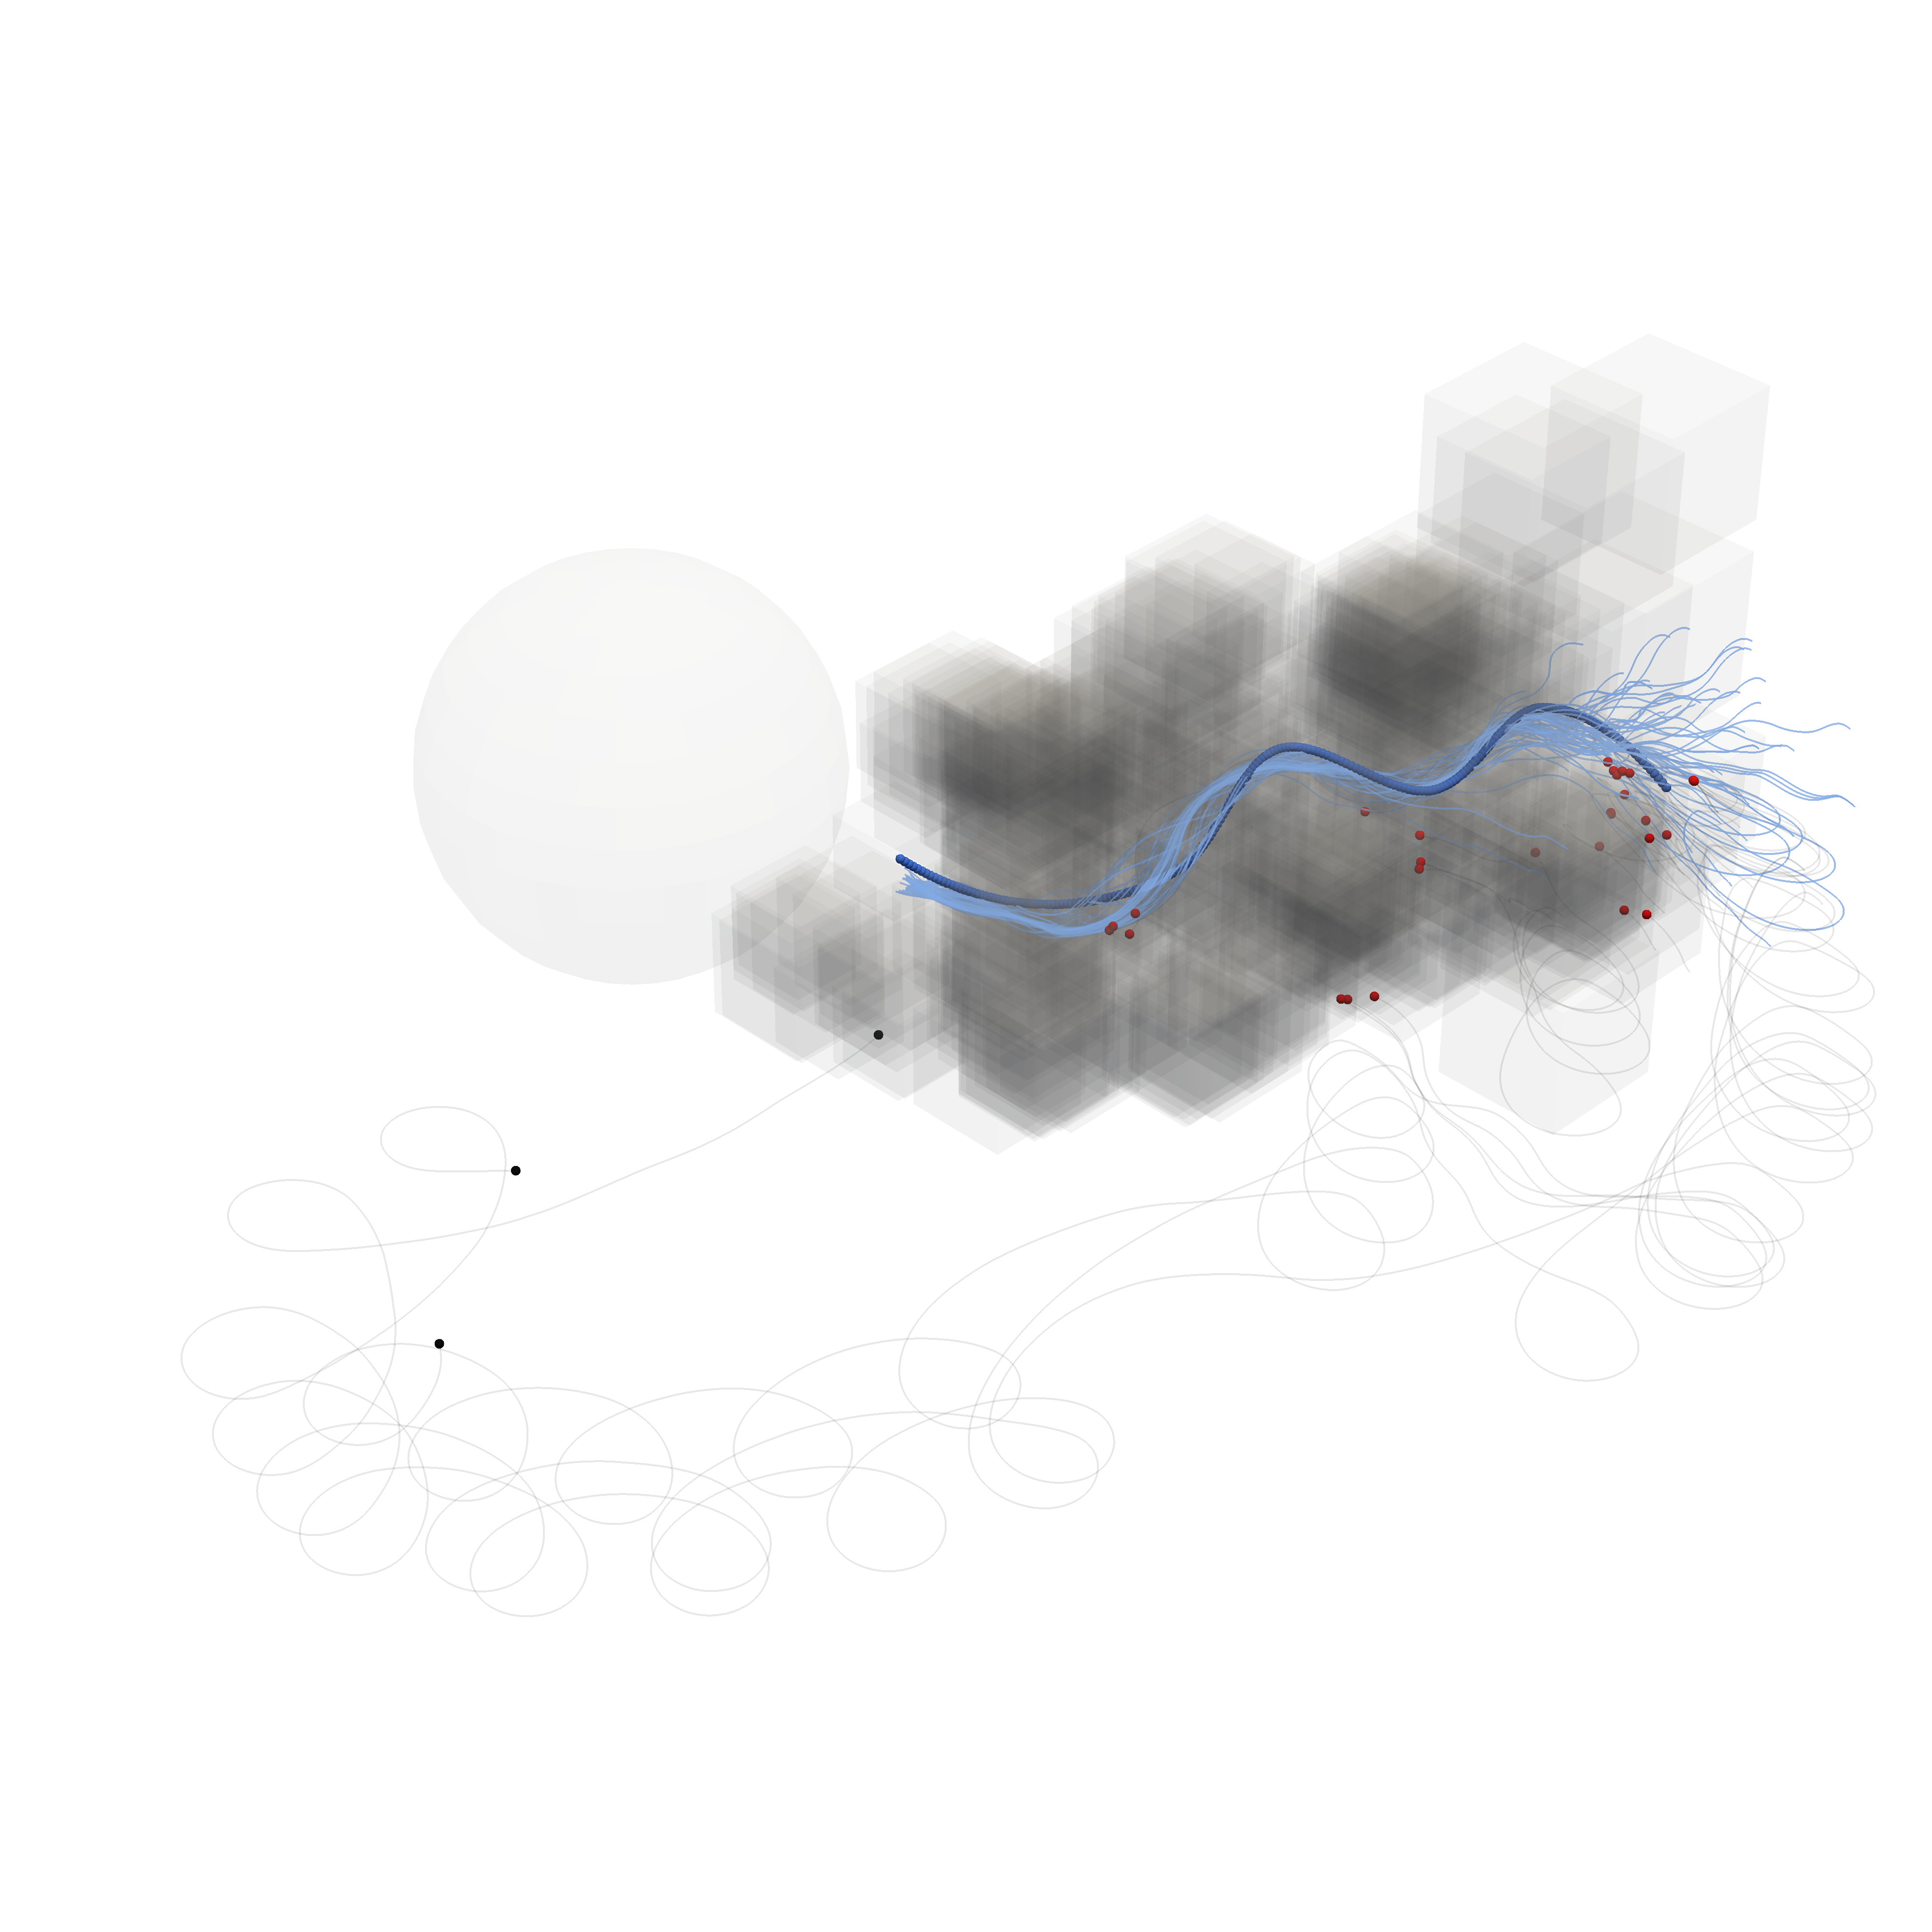

In [55]:
# Plot House_hard view 1

if test_scen in ["house_hard", "house_hard_obstacles"]:
    for hv in [1,2,3,4]: # View from two angles, must have separate instances. Solved with hv variable in plotter func. "hv=HouseView"
        multiplotter = Plotter3DMultiTraj(obstacles=obstacles,
                                            path=path,
                                            drone_trajs=all_drone_trajs,
                                            initial_position=init_pos,
                                            cum_rewards=successes,  # cum_rewards,
                                            scene=test_scen,
                                            save=True)
        multiplotter.plot_scene_and_trajs(save_path=os.path.join(output_path, "plots", f"multiplot_hv{hv}.pdf"),
                                        azimuth=90,
                                        hv=hv)
        #del multiplotter
else:
    multiplotter = Plotter3DMultiTraj(obstacles=obstacles,
                                    path=path,
                                    drone_trajs=all_drone_trajs,
                                    initial_position=init_pos,
                                    cum_rewards=successes,  # cum_rewards,
                                    scene=test_scen,
                                    collisions=collisions,
                                    save=True)
    multiplotter.plot_scene_and_trajs(save_path=os.path.join(output_path, "plots", f"multiplot.pdf"),
                                    azimuth=90)